In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-26 17:40:01.992238: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 17:40:03.366205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-26 17:40:03.366326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-26 17:40:03.366337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_tests'


single_lens_data = np.load(os.path.join(data_path, 'single_lens_measurements.npy'))
double_lens_data = np.load(os.path.join(data_path, 'double_lens_measurements.npy'))
many_lens_data = np.load(os.path.join(data_path, 'many_lens_measurements.npy'))


data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min())
data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max())


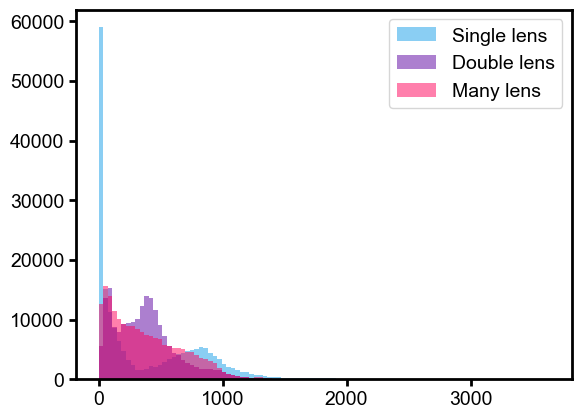

In [3]:
# plot histograms
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99.5), np.percentile(double_lens_data, 99.5), np.percentile(many_lens_data, 99.5))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:8].ravel(), bins=bins, label='Single lens', alpha=0.5)
_ = ax.hist(double_lens_data[:8].ravel(), bins=bins, label='Double lens', alpha=0.5)
_ = ax.hist(many_lens_data[:8].ravel(), bins=bins, label='Many lens', alpha=0.5)
ax.legend()

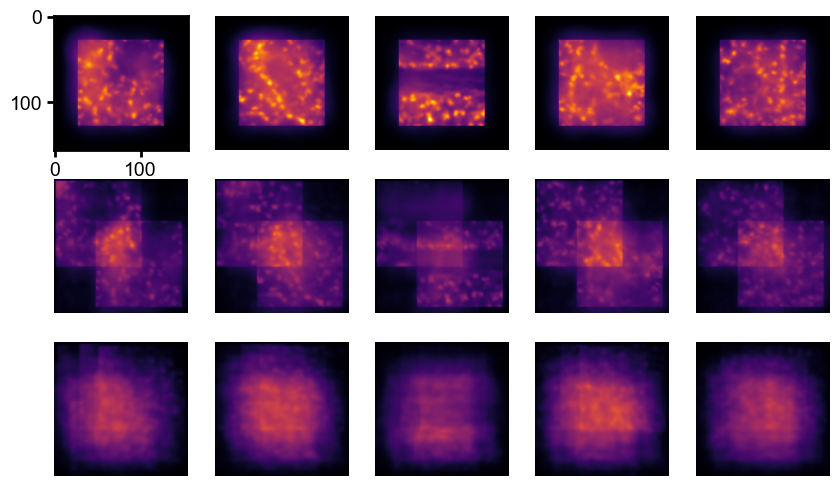

In [4]:
# plot 5 of the initial and final measurements

vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for i in range(5):
    axs[0, i].imshow(single_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[1, i].imshow(double_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(many_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    if i != 0:
        axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

In [31]:
# Try nearest neighbor distance
from encoding_information.information_estimation import *


@partial(jit, static_argnums=1)
def nearest_neighbors_distance(X, k):
    """
    Compute the distance to the kth nearest neighbor for each point in X by
    exhaustively searching all points in X.
    
    X : ndarray, shape (n_samples, W, H) or (n_samples, num_features)
    k : int
    """
    X = X.reshape(X.shape[0], -1)
    distance_matrix = np.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=-1)
    kth_nn_index = np.argsort(distance_matrix, axis=-1)[:, k]
    kth_nn = X[kth_nn_index, :]
    kth_nn_dist = np.sum(np.abs(X - kth_nn), axis=-1)
    # kth_nn_dist = np.sqrt(np.sum((X - kth_nn)**2, axis=-1))
    return kth_nn_dist


k = 1000
print(nearest_neighbors_distance(single_lens_patches, k).mean(),
        nearest_neighbors_distance(double_lens_patches, k).mean(), 
        nearest_neighbors_distance(many_lens_patches, k).mean())


177129.67 109173.64 116689.89


# Generate and train

In [5]:
patch_size = 80


pcnn_path = data_path + '/pcnn'
gaussian_path = data_path + '/gaussian'

#mkdirs if necessary
for path in [pcnn_path, gaussian_path]:
    if not os.path.exists(path):
        os.makedirs(path)


for i in range(10):

    single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_noisy_patches = add_noise(single_lens_patches)
    double_lens_noisy_patches = add_noise(double_lens_patches)
    many_lens_noisy_patches = add_noise(many_lens_patches)


    single_lens_mi_pcnn = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, entropy_model='pixel_cnn', verbose=True)
    double_lens_mi_pcnn = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, entropy_model='pixel_cnn', verbose=True)
    many_lens_mi_pcnn = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, entropy_model='pixel_cnn', verbose=True)

    # do gaussian
    single_lens_mi_gaussian = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, verbose=True)
    double_lens_mi_gaussian = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches,  verbose=True)
    many_lens_mi_gaussian = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, verbose=True)


    # count the number of files in each directory, and then create a suffix for the next file. 
    # assume they are save in files like single_lens_pcnn_1.npy, single_lens_pcnn_2.npy, etc.
    def get_next_suffix(path):
        if not os.path.exists(path):
            return 0
        else:
            return len([f for f in os.listdir(path) if 'single_lens_pcnn' in f])
                
    suffix = get_next_suffix(pcnn_path)

    np.save(os.path.join(pcnn_path, f'single_lens_pcnn_patch_{patch_size}_{suffix}.npy'), single_lens_mi_pcnn)
    np.save(os.path.join(pcnn_path, f'double_lens_pcnn_patch_{patch_size}_{suffix}.npy'), double_lens_mi_pcnn)
    np.save(os.path.join(pcnn_path, f'many_lens_pcnn_patch_{patch_size}_{suffix}.npy'), many_lens_mi_pcnn)

    np.save(os.path.join(gaussian_path, f'single_lens_gaussian_patch_{patch_size}_{suffix}.npy'), single_lens_mi_pcnn)
    np.save(os.path.join(gaussian_path, f'double_lens_gaussian_patch_{patch_size}_{suffix}.npy'), double_lens_mi_pcnn)
    np.save(os.path.join(gaussian_path, f'many_lens_gaussian_patch_{patch_size}_{suffix}.npy'), many_lens_mi_pcnn)

100%|██████████| 5000/5000 [01:32<00:00, 53.76it/s]
2024-01-26 17:47:40.888053: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 115200000 exceeds 10% of free system memory.
2024-01-26 17:47:41.112950: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 115200000 exceeds 10% of free system memory.
2024-01-26 17:47:55.300258: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 103680000 exceeds 10% of free system memory.
2024-01-26 17:47:55.382554: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 103680000 exceeds 10% of free system memory.


Initial validation NLL: 574.47


Epoch 1: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Epoch 1: validation NLL: 6.69


Epoch 2: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


Epoch 2: validation NLL: 6.57


Epoch 3: 100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Epoch 3: validation NLL: 6.54


Epoch 4: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


Epoch 4: validation NLL: 6.09


Epoch 5: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


Epoch 5: validation NLL: 5.33


Epoch 6: 100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


Epoch 6: validation NLL: 5.46


Epoch 7: 100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


Epoch 7: validation NLL: 5.28


Epoch 8: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


Epoch 8: validation NLL: 7.48


Epoch 9: 100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


Epoch 9: validation NLL: 5.05


Epoch 10: 100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Epoch 10: validation NLL: 5.72


Epoch 11: 100%|██████████| 100/100 [00:24<00:00,  4.00it/s]


Epoch 11: validation NLL: 5.23


Epoch 12: 100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


Epoch 12: validation NLL: 5.35


Epoch 13: 100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Epoch 13: validation NLL: 5.11


Epoch 14: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


Epoch 14: validation NLL: 5.24


Epoch 15: 100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Epoch 15: validation NLL: 7.28


Epoch 16: 100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


Epoch 16: validation NLL: 7.16


Epoch 17: 100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Epoch 17: validation NLL: 7.16


Epoch 18: 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


Epoch 18: validation NLL: 7.16


Epoch 19: 100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


Epoch 19: validation NLL: 7.16


Epoch 20: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Epoch 20: validation NLL: 7.16


Epoch 21: 100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


Epoch 21: validation NLL: 7.15


Epoch 22: 100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Epoch 22: validation NLL: 7.15


Epoch 23: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


Epoch 23: validation NLL: 7.15


Epoch 24: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


Epoch 24: validation NLL: 7.15


Epoch 25: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Epoch 25: validation NLL: 7.15


Epoch 26: 100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


Epoch 26: validation NLL: 7.15


Epoch 27: 100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


Epoch 27: validation NLL: 7.15


Epoch 28: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 28: validation NLL: 7.15


Epoch 29: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 29: validation NLL: 7.15


Epoch 30: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


Epoch 30: validation NLL: 7.15


Epoch 31: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


Epoch 31: validation NLL: 7.15


Epoch 32: 100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


Epoch 32: validation NLL: 7.15


Epoch 33: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


Epoch 33: validation NLL: 7.15


Epoch 34: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Epoch 34: validation NLL: 7.15


Epoch 35: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 35: validation NLL: 7.15


Epoch 36: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Epoch 36: validation NLL: 7.15


Epoch 37: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


Epoch 37: validation NLL: 7.15


Epoch 38: 100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Epoch 38: validation NLL: 7.15


Epoch 39: 100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


Epoch 39: validation NLL: 7.15


Epoch 40: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Epoch 40: validation NLL: 7.15


Epoch 41: 100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


Epoch 41: validation NLL: 7.15


Epoch 42: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


Epoch 42: validation NLL: 7.15


Epoch 43: 100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


Epoch 43: validation NLL: 7.15


Epoch 44: 100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


Epoch 44: validation NLL: 7.15


Epoch 45: 100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


Epoch 45: validation NLL: 7.15


Epoch 46: 100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


Epoch 46: validation NLL: 7.15


Epoch 47: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


Epoch 47: validation NLL: 7.15


Epoch 48: 100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


Epoch 48: validation NLL: 7.15


Epoch 49: 100%|██████████| 100/100 [00:21<00:00,  4.56it/s]


Epoch 49: validation NLL: 7.15
Estimated H(Y|X) = 4.433 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.080 differential entropy/pixel
Estimated I(Y;X) = 0.933 bits/pixel


2024-01-26 18:10:58.860896: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 115200000 exceeds 10% of free system memory.


Initial validation NLL: 415.51


Epoch 1: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


Epoch 1: validation NLL: 6.64


Epoch 2: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


Epoch 2: validation NLL: 6.48


Epoch 3: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s]


Epoch 3: validation NLL: 5.65


Epoch 4: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


Epoch 4: validation NLL: 5.62


Epoch 5: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]


# Load and plot

ValueError: x and y can be no greater than 2D, but have shapes (2,) and (2, 5000, 80, 80)

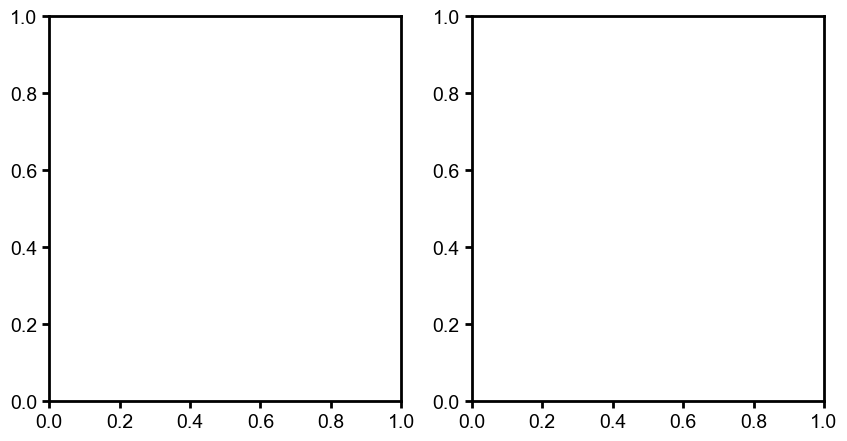

In [6]:
# load the data
patch_size = 80

pcnn_path = data_path + '/pcnn'
gaussian_path = data_path + '/gaussian'

# determine num replicates by number of files in directory
num_replicates = len([f for f in os.listdir(pcnn_path) if 'single_lens_pcnn' in f])

# load the data
single_lens_pcnn_data = []
double_lens_pcnn_data = []
many_lens_pcnn_data = []

single_lens_gaussian_data = []
double_lens_gaussian_data = []
many_lens_gaussian_data = []

for i in range(num_replicates):
    single_lens_pcnn_data.append(np.load(os.path.join(pcnn_path, f'single_lens_pcnn_patch_{patch_size}_{i}.npy')))
    double_lens_pcnn_data.append(np.load(os.path.join(pcnn_path, f'double_lens_pcnn_patch_{patch_size}_{i}.npy')))
    many_lens_pcnn_data.append(np.load(os.path.join(pcnn_path, f'many_lens_pcnn_patch_{patch_size}_{i}.npy')))

    single_lens_gaussian_data.append(np.load(os.path.join(gaussian_path, f'single_lens_gaussian_patch_{patch_size}_{i}.npy')))
    double_lens_gaussian_data.append(np.load(os.path.join(gaussian_path, f'double_lens_gaussian_patch_{patch_size}_{i}.npy')))
    many_lens_gaussian_data.append(np.load(os.path.join(gaussian_path, f'many_lens_gaussian_patch_{patch_size}_{i}.npy')))


# plot it 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.array(single_lens_pcnn_data), label='Single lens')
ax[0].plot(np.array(double_lens_pcnn_data), label='Double lens')
ax[0].plot(np.array(many_lens_pcnn_data), label='Many lens')
ax[0].legend()

ax[1].plot(np.array(single_lens_gaussian_data), label='Single lens')
ax[1].plot(np.array(double_lens_gaussian_data), label='Double lens')
ax[1].plot(np.array(many_lens_gaussian_data), label='Many lens')
ax[1].legend()
